In [9]:
# Starting the Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Titanic').getOrCreate()
  
# Reading the data
df = spark.read.csv('titanic.csv',inferSchema=True, header=True)
  
# Showing the data
df.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [10]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [11]:
df.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [12]:
# Selecting the columns which are required 
# to train and test the model.
rm_columns = df.select(['Survived','Pclass',
                       'Sex','Age','SibSp',
                       'Parch','Fare','Embarked'])
  
# Drops the data having null values
result= rm_columns.na.drop()
  
# Again showing the data
my_final_data=result
my_final_data.show()

+--------+------+------+----+-----+-----+-------+--------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|
+--------+------+------+----+-----+-----+-------+--------+
|       0|     3|  male|22.0|    1|    0|   7.25|       S|
|       1|     1|female|38.0|    1|    0|71.2833|       C|
|       1|     3|female|26.0|    0|    0|  7.925|       S|
|       1|     1|female|35.0|    1|    0|   53.1|       S|
|       0|     3|  male|35.0|    0|    0|   8.05|       S|
|       0|     1|  male|54.0|    0|    0|51.8625|       S|
|       0|     3|  male| 2.0|    3|    1| 21.075|       S|
|       1|     3|female|27.0|    0|    2|11.1333|       S|
|       1|     2|female|14.0|    1|    0|30.0708|       C|
|       1|     3|female| 4.0|    1|    1|   16.7|       S|
|       1|     1|female|58.0|    0|    0|  26.55|       S|
|       0|     3|  male|20.0|    0|    0|   8.05|       S|
|       0|     3|  male|39.0|    1|    5| 31.275|       S|
|       0|     3|female|14.0|    0|    0| 7.8542|       

In [13]:


# Importing the required libraries
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
  
# Converting the Sex Column
sexIdx = StringIndexer(inputCol='Sex',
                               outputCol='SexIndex')
sexEncode = OneHotEncoder(inputCol='SexIndex',
                               outputCol='SexVec')
  
# Converting the Embarked Column
embarkIdx = StringIndexer(inputCol='Embarked',
                               outputCol='EmbarkIndex')
embarkEncode = OneHotEncoder(inputCol='EmbarkIndex',
                               outputCol='EmbarkVec')
  
# Vectorizing the data into a new column "features" 
# which will be our input/features class
assembler = VectorAssembler(inputCols=['Pclass',
                                       'SexVec','Age',
                                       'SibSp','Parch',
                                       'Fare','EmbarkVec'],
                                    outputCol='features')

In [14]:

# Importing Pipeline and Model
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
  
log_reg = LogisticRegression(featuresCol='features',
                             labelCol='Survived')
  
# Creating the pipeline
pipeline = Pipeline(stages=[sexIdx, embarkIdx,
                            sexEncode, embarkEncode,
                            assembler, log_reg])

In [15]:
# Splitting the data into train and test
train_data, test_data = my_final_data.randomSplit([0.7, .3])
  
# Fitting the model on training data
fit_model = pipeline.fit(train_data)
  
# Storing the results on test data
results = fit_model.transform(test_data)
  
# Showing the results
results.show()

+--------+------+------+----+-----+-----+--------+--------+--------+-----------+-------------+-------------+--------------------+--------------------+--------------------+----------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|    Fare|Embarked|SexIndex|EmbarkIndex|       SexVec|    EmbarkVec|            features|       rawPrediction|         probability|prediction|
+--------+------+------+----+-----+-----+--------+--------+--------+-----------+-------------+-------------+--------------------+--------------------+--------------------+----------+
|       0|     1|female| 2.0|    1|    2|  151.55|       S|     1.0|        0.0|    (1,[],[])|(2,[0],[1.0])|[1.0,0.0,2.0,1.0,...|[-4.2264934380489...|[0.01439331605967...|       1.0|
|       0|     1|female|50.0|    0|    0| 28.7125|       C|     1.0|        1.0|    (1,[],[])|(2,[1],[1.0])|(8,[0,2,5,7],[1.0...|[-2.5635832619704...|[0.07151923286838...|       1.0|
|       0|     1|  male|19.0|    3|    2|   263.0|       S|     0.0|        0.0|(1,[0

In [16]:
# Importing the evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
  
# Calling the evaluator
res = BinaryClassificationEvaluator (rawPredictionCol='prediction',labelCol='Survived')
  
# Evaluating the AUC on results
ROC_AUC = res.evaluate(results)
print ("ROC_AUC",ROC_AUC)

ROC_AUC 0.764102564102564


In [17]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Create a Spark session
spark = SparkSession.builder.appName("LinearRegressionExample").getOrCreate()

# Load your regression-compatible dataset
# Replace 'path_to_your_dataset' with the actual path to your dataset
data = spark.read.csv('seeds.csv', header=True, inferSchema=True)

# Prepare the data
feature_columns = data.columns[:-1]
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
data = assembler.transform(data)

# Rename the target column to 'label'
data = data.withColumnRenamed('v7', 'label')

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)

# Create the LinearRegression model
lr = LinearRegression(featuresCol='features', labelCol='label')

# Train the model
model = lr.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) =", rmse)

Root Mean Squared Error (RMSE) = 0.11563206603181264


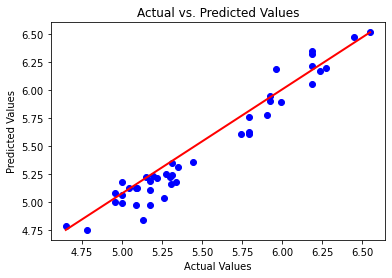

In [18]:
# Collect the data for plotting
actual_values = np.array(test_data.select('label').collect())
predicted_values = np.array(predictions.select('prediction').collect())
# Plot the data points and regression line
plt.scatter(actual_values, predicted_values, color='blue')
plt.plot([min(actual_values), max(actual_values)], [min(predicted_values), max(predicted_values)], color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

In [4]:
spark.stop()

In [23]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np

# Create a Spark session
spark = SparkSession.builder.appName("LogisticRegressionExample").getOrCreate()

# Load the Seeds dataset
data = spark.read.csv('titanic.csv', header=True, inferSchema=True)
columns_to_drop=['Name','Sex','Ticket','Cabin']
data=data.drop(*columns_to_drop)
# Prepare the data
feature_columns = data.columns[:-1]
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
data = assembler.transform(data)

# Rename the target column to 'label'
data = data.withColumnRenamed('Embarked', 'label')

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)


In [25]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [26]:
spark = SparkSession.builder \
    .appName("TitanicLogisticRegression") \
    .getOrCreate()


In [27]:
data = spark.read.csv("titanic.csv", header=True, inferSchema=True)


In [28]:
# Select relevant features and target
selected_features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
target_column = "Survived"
data = data.select(selected_features + [target_column])

# Handle missing values
data = data.dropna()

# Convert categorical variables to numerical using StringIndexer
from pyspark.ml.feature import StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index").fit(data) for column in ["Sex", "Embarked"]]
for indexer in indexers:
    data = indexer.transform(data)

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=[column + "_index" if column in ["Sex", "Embarked"] else column for column in selected_features], outputCol="features")
data = assembler.transform(data)

# Prepare the target column
data = data.withColumn("label", data[target_column])


In [29]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)


In [30]:
log_reg = LogisticRegression(featuresCol="features", labelCol="label")
model = log_reg.fit(train_data)


In [31]:
predictions = model.transform(test_data)

# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("Area under ROC:", auc)


Area under ROC: 0.8460939931528165
